<a href="https://colab.research.google.com/github/Hrithik2212/Neural-Machine-Translation--English-to-Tamil/blob/main/02_NMT_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets
!pip install -q tokenizers
!pip install -q stanza

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import vocab

import random
import math

from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.trainers import BpeTrainer, WordLevelTrainer
from tokenizers.models import WordLevel, BPE
from tokenizers.pre_tokenizers import Whitespace,WhitespaceSplit

In [208]:
256 % 6

4

In [209]:
config=dict(
    # RUN CONFIG:
    RUN_NAME='single_gpu_run',
    RUN_DESCRIPTION='No description',
    RUNS_FOLDER_PTH='../runs',
    # DATA CONFIG:
    DATASET_SIZE=30000, # WARN: This is too small but makes it easy to go through the notebook fast
    TEST_PROPORTION=0.01,
    MAX_SEQ_LEN=40,
    VOCAB_SIZE=50000,
    TOKENIZER_TYPE='wordlevel',
    # TRAINING CONFIG:
    BATCH_SIZE=128,
    GRAD_ACCUMULATION_STEPS=2048//48,
    WORKER_COUNT=2,
    EPOCHS=50,
    # OPTIMIZER CONFIG:
    BETAS=(0.9, 0.98),
    EPS=1e-9,
    # SCHEDULER CONFIG:
    N_WARMUP_STEPS=4000,
    # MODEL CONFIG:
    D_MODEL=256,
    N_BLOCKS=4,
    N_HEADS=4,
    D_FF=2048,
    DROPOUT_PROBA=0.1,
    # OTHER:
    MODEL_SAVE_EPOCH_CNT=10,
    DEVICE='gpu',
    LABEL_SMOOTHING=0.1,
)

In [4]:
eng_file = '/content/drive/MyDrive/en-ta/train.en'
tamil_file = '/content/drive/MyDrive/en-ta/train.ta'

In [5]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(tamil_file, 'r') as file:
    tamil_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
tamil_sentences = [sentence.rstrip('\n') for sentence in tamil_sentences]

In [6]:
# filter out sentences which contains letters other than whats listed below
tamil_vocabulary = [ ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                      "ஃ", "அ", "ஆ", "இ", "ஈ", "உ", "ஊ", "எ", "ஏ", "ஐ", "ஒ", "ஓ", "ஔ",
                      "க", "ங", "ச", "ஜ", "ஞ", "ட", "ண",
                      "த", "ந", "ன", "ப", "ம", "ய", "ர",
                      "ற", "ல", "ள", "ழ", "வ", "ஶ", "ஷ", "ஸ", "ஹ",
                      "ா", "ி", "ீ", "ு", "ூ", "ெ", "ே", "ை", "ொ", "ோ", "ௌ", "்", "ௗ",
                      "௦", "௧", "௨", "௫", "௬", "௲", "௳"
                      ]

english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~']

In [7]:
def is_valid_tokens(sentence , vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

valid_sentence_indicies = []
for index in range(len(english_sentences[:500000])):
    tamil_sentence, english_sentence = tamil_sentences[index], english_sentences[index]
    if is_valid_tokens(tamil_sentence, tamil_vocabulary) \
      and is_valid_tokens(english_sentence , english_vocabulary):
        valid_sentence_indicies.append(index)

In [8]:
TOTAL_SENTENCES = 100000 # lets take 50000 valid sentences to train the model
x = [english_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]
y = [tamil_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]

In [10]:
import stanza

stanza.download('ta')
nlp_ta = stanza.Pipeline('ta', processors='tokenize')
def tokenize_ta(text):
    """
    Tokenizes Tamil text from a string into a list of strings
    """
    doc = nlp_ta(text)
    return [word.text for sent in doc.sentences for word in sent.words]


INFO:stanza:Downloading default packages for language: ta (Tamil) ...
INFO:stanza:File exists: /root/stanza_resources/ta/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ta (Tamil):
| Processor | Package |
-----------------------
| tokenize  | ttb     |
| mwt       | ttb     |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!


In [24]:
import collections
tamil_words_counter = collections.Counter([word for sentence in y for word in sentence.split()])
tamil_words_counter.most_common(10)
ta_vocab = vocab(tamil_words_counter, min_freq=1 , specials=("[PAD]", "[UNK]", "[BOS]", "[EOS]"))
ta_vocab.set_default_index(ta_vocab["[UNK]"])

In [89]:
english_words_counter = collections.Counter([word for sentence in x for word in sentence.split()])
en_vocab = vocab(english_words_counter, min_freq=1, specials=("[PAD]", "[UNK]", "[BOS]", "[EOS]"))
ta_vocab.set_default_index(en_vocab["[UNK]"])

In [25]:
len(ta_vocab)

106379

In [91]:
import pandas as pd
data =  pd.DataFrame({"English":x , "Tamil":y })
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  50000 non-null  object
 1   Tamil    50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [92]:
data.sample(5)

,English,Tamil
27632,the ip/trr ratio and debt/gsdp ratio based on ...,ஆ) இரண்டாண்டுகளுக்கு முந்தைய நிதிக் கணக்கின் ப...
48769,in it he states:,அப்புகாரில் அவர் கூறியிருப்பதாவது:-
27769,facebook ceo mark zuckerberg made the announce...,"ஃபேஸ்புக் நிறுவனர் மார்க், நடந்த பிழைக்கு பகிர..."
14538,verily we created man out of a drop of intermi...,"(பின்னர் ஆண், பெண்) கலப்பான இந்திரியத்துளியிலி..."
23158,they choose you.,உங்களிலிருந்து உங்களை தேர்வு செய்வீர்கள்.


In [53]:
ta_tokenizer = Tokenizer(WordLevel(vocab=ta_vocab.get_stoi() ,unk_token="[UNK]"))
ta_tokenizer.pre_tokenizer = WhitespaceSplit()
trainer_src = WordLevelTrainer(vocab_size=100000, special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"])

# Configure batch iterators to train tokenizers from memory
def batch_iterator_src(batch_size=10000):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]['Tamil']

# Train tokenizers
ta_tokenizer.train_from_iterator(batch_iterator_src(), trainer=trainer_src, length=len(data))

# Configure postprocessing to add [BOS] and [EOS] tokens to trg sequence
ta_tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", 2),
        ("[EOS]", 3),
    ],
)

In [54]:
ta_tokenizer.get_vocab_size()

100000

In [55]:
encoding = ta_tokenizer.encode(y[5])
print(encoding.tokens)
print(encoding.ids)

['[BOS]', 'இந்த', 'எல்லா', 'உயிர்களிலும்', 'நீங்கள்', 'கண்டுபிடிக்கப்', 'போவது', 'இதுதான்', 'என்று', 'நான்', 'நினைக்கிறேன்', 'உங்கள்', 'சொந்த', 'அனுபவம்', 'நீங்கள்', 'தேர்ந்தெடுக்கும்', 'ஒரு', 'நல்ல', 'ஒப்பந்தத்தை', 'வண்ணமயமாக்குகிறது', 'மேலே', 'நெருக்கமாக', 'அல்லது', 'கீழே', 'நெருக்கமாக', 'மற்றும்', 'யோசனை', 'ஒரு', 'உடன்பிறப்பு', 'அல்லது', 'இனி', 'சம்பந்தப்படாத', 'குழந்தை', 'உங்கள்', 'அனுபவம்', 'மிகவும்', 'வேதனையாக', 'இருந்தால்', 'குடும்பத்துடன்,', 'பின்னர்', 'நீங்கள்', 'அதை', 'கீழே', 'தள்ளும்', 'வாய்ப்புகள்', 'உள்ளன.', '[EOS]']
[2, 5, 317, 48624, 23, 54667, 5791, 656, 7, 10, 27436, 74, 670, 2270, 23, 26835, 6, 113, 4204, 99119, 1886, 3216, 28, 686, 3216, 4, 5842, 6, 47434, 28, 657, 64058, 445, 74, 2270, 63, 32055, 1391, 58701, 65, 23, 57, 686, 72362, 1084, 122, 3]


In [93]:
en_tokenizer = Tokenizer(WordLevel(vocab=en_vocab.get_stoi() ,unk_token="[UNK]"))
en_tokenizer.pre_tokenizer = WhitespaceSplit()
en_tokenizer.normalizer=normalizers.Sequence([NFD(),StripAccents(), Lowercase()])
en_tokenizer.pre_tokenizer = WhitespaceSplit()

trainer_src = WordLevelTrainer(vocab_size=100000, special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"])

# Configure batch iterators to train tokenizers from memory
def batch_iterator_src(batch_size=10000):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]['English']

# Train tokenizers
en_tokenizer.train_from_iterator(batch_iterator_src(), trainer=trainer_src, length=len(data))

# Configure postprocessing to add [BOS] and [EOS] tokens to trg sequence
en_tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", 2),
        ("[EOS]", 3),
    ],
)

In [194]:
en_tokenizer.get_vocab_size()

53671

In [94]:
encoding = en_tokenizer.encode(x[5])
print(encoding.tokens)
print(encoding.ids)

['[BOS]', 'i', 'think', 'with', 'all', 'these', 'lives', 'what', "you're", 'going', 'to', 'find', 'is', 'that', 'your', 'own', 'experience', 'tends', 'to', 'color', 'a', 'good', 'deal', 'which', 'one', 'you', 'pick', 'as', 'closer', 'to', 'the', 'top', 'or', 'closer', 'to', 'the', 'bottom', 'and', 'the', 'idea', 'of', 'a', 'sibling', 'or', 'a', 'child', "that's", 'no', 'longer', 'involved', 'with', 'the', 'family', 'if', 'your', 'experience', 'with', 'that', 'is', 'very', 'painful,', 'then', 'the', 'chances', 'are', 'that', "you'll", 'kind', 'of', 'push', 'that', 'one', 'to', 'the', 'bottom.', '[EOS]']
[2, 25, 269, 22, 43, 94, 431, 38, 5443, 157, 7, 352, 10, 12, 57, 302, 1052, 21735, 7, 3399, 9, 127, 1203, 68, 47, 29, 4485, 27, 3398, 7, 4, 675, 50, 3398, 7, 4, 3805, 6, 4, 1733, 5, 9, 21236, 50, 9, 372, 732, 42, 1292, 844, 22, 4, 171, 85, 57, 1052, 22, 12, 10, 105, 43471, 95, 4, 5087, 15, 12, 9820, 1014, 5, 5330, 12, 47, 7, 4, 29444, 3]


In [96]:
from datasets import Dataset

data = Dataset.from_pandas(data)


In [97]:
def preprocess_data(data, en_tokenizer,ta_tokenizer, max_seq_len , test_proportion):

    # Tokenize
    def tokenize(example):
        return {
            'translation_src': en_tokenizer.encode(example['English']).ids,
            'translation_trg': ta_tokenizer.encode(example['Tamil']).ids,
        }
    data=data.map(tokenize)

    # Compute sequence lengths
    def sequence_length(example):
        return {
            'length_src': [len(item) for item in example['English']],
            'length_trg': [len(item) for item in example['Tamil']],
        }
    data=data.map(sequence_length, batched=True, batch_size=10000)

    # Filter by sequence lengths
    def filter_long(example):
        return example['length_src']<= max_seq_len and example['length_trg']<=max_seq_len
    data=data.filter(filter_long)

    data=data.train_test_split(test_size=test_proportion)

    # Sort each split by length for dynamic batching (see CustomBatchSampler)
    data['train']=data['train'].sort('length_src', reverse=True)
    data['test']=data['test'].sort('length_src', reverse=True)
    return data

In [98]:
data = preprocess_data(data , en_tokenizer , ta_tokenizer , 65 , 0.2)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [99]:
len(data['train']) , len(data['test'])

(22888, 5723)

In [166]:
class TranslationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        src_encoded=self.dataset[idx]['translation_src']
        trg_encoded=self.dataset[idx]['translation_trg']

        # Determine the maximum sequence length
        max_len = max(len(src_encoded), len(trg_encoded))

        # Pad the sequences to have the same length
        src_encoded = src_encoded + [0]*(max_len - len(src_encoded))
        trg_encoded = trg_encoded + [0]*(max_len - len(trg_encoded))
        return [
            torch.tensor(src_encoded),
            torch.tensor(trg_encoded),
        ]

In [167]:
train_ds = TranslationDataset(data['train'])
val_ds = TranslationDataset(data['test'])

In [168]:
train_ds[0]

[tensor([    2,  2197, 28405,   668,  1568,    16,   272,    20,     4,  2104,
          5304,     3]),
 tensor([    2,   206, 66698, 91130, 68458,   135,  1273,     3,     0,     0,
             0,     0])]

In [169]:
en_vocab["[PAD]"] , ta_vocab["[PAD]"]

(0, 0)

In [170]:
def pad_collate_fn(batch):
    src_sentences,trg_sentences=[],[]
    for sample in batch:
        src_sentences+=[sample[0]]
        trg_sentences+=[sample[1]]

    src_sentences = pad_sequence(src_sentences, batch_first=True, padding_value=0)
    trg_sentences = pad_sequence(trg_sentences, batch_first=True, padding_value=0)

    return src_sentences, trg_sentences

In [171]:
# example-use
batch=[
    (torch.tensor([1,2,3,4]),torch.tensor([1,2,3,4,5,6,7])), #x's
    (torch.tensor([1,2,3,4,5,6]), torch.tensor([1,2]))  # y's
]

pad_collate_fn(batch)


(tensor([[1, 2, 3, 4, 0, 0],
         [1, 2, 3, 4, 5, 6]]),
 tensor([[1, 2, 3, 4, 5, 6, 7],
         [1, 2, 0, 0, 0, 0, 0]]))

In [172]:

def chunk(indices, chunk_size):
    return torch.split(torch.tensor(indices), chunk_size)

class CustomBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):

        # Dataset is already sorted so just chunk indices
        # into batches of indices for sampling
        self.batch_size=batch_size
        self.indices=range(len(dataset))
        self.batch_of_indices=list(chunk(self.indices, self.batch_size))
        self.batch_of_indices = [batch.tolist() for batch in self.batch_of_indices]

    def __iter__(self):
        random.shuffle(self.batch_of_indices)
        return iter(self.batch_of_indices)

    def __len__(self):
        return len(self.batch_of_indices)

In [173]:
custom_batcher_train = CustomBatchSampler(train_ds, config['BATCH_SIZE'])
custom_batcher_val = CustomBatchSampler(val_ds, config['BATCH_SIZE'])


In [174]:
# example-use
dummy_batcher = CustomBatchSampler(train_ds, 3)
dummy_dl=DataLoader(train_ds, collate_fn=pad_collate_fn , batch_sampler=dummy_batcher, pin_memory=True)
print(len(dummy_dl))
for x ,y  in dummy_dl:
    print('Shapes: ')
    print('-'*10)
    print(x.size())
    print(y.size())
    print()


    print('e.g. src batch (see there is minimal/no padding):')
    print('-'*10)
    print(x.numpy())

    break

7630
Shapes: 
----------
torch.Size([3, 9])
torch.Size([3, 9])

e.g. src batch (see there is minimal/no padding):
----------
[[    2    36    14    13    23  9341     4  5304     3]
 [    2  3137     6   290    35 20030     3     0     0]
 [    2    12   524    17    23    30  4894     3     0]]


In [192]:
train_dl=DataLoader(train_ds, collate_fn=pad_collate_fn, batch_sampler=custom_batcher_train, pin_memory=True)
val_dl=DataLoader(val_ds, collate_fn=pad_collate_fn, batch_sampler=custom_batcher_val, pin_memory=True)


## Transformer Architecture

In [175]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=500, dropout_proba=0.1):
        super(PositionalEncoding, self).__init__()
        self.max_seq_len=max_seq_len
        self.d_model=d_model

        pe_table=self.get_pe_table()
        self.register_buffer('pe_table' , pe_table)

        self.dropout=nn.Dropout(dropout_proba)

    def get_pe_table(self):
        position_idxs=torch.arange(self.max_seq_len).unsqueeze(1)
        embedding_idxs=torch.arange(self.d_model).unsqueeze(0)

        angle_rads = position_idxs * 1/torch.pow(10000, (2*(embedding_idxs//2))/self.d_model)

        angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

        pe_table = angle_rads.unsqueeze(0) # So we can apply it to a batch

        return pe_table

    def forward(self, embeddings_batch):
        seq_len = embeddings_batch.size(1)
        pe_batch = self.pe_table[:, :seq_len].clone().detach()
        return self.dropout(embeddings_batch + pe_batch)

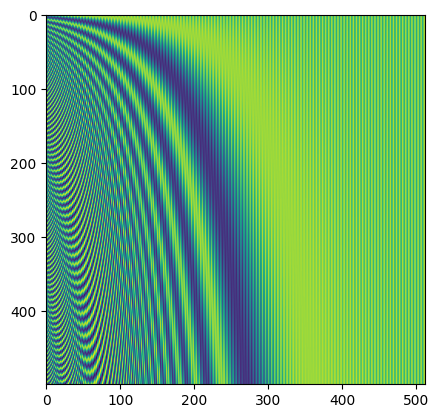

In [176]:
# example-use
import matplotlib.pyplot as plt

positional_encoding=PositionalEncoding(512, 500)
pe_table=positional_encoding.get_pe_table()

plt.imshow(pe_table.squeeze(0).numpy())

In [177]:
class AddAndNorm(nn.Module):
    def __init__(self, d_model):
        super(AddAndNorm, self).__init__()

        self.layer_norm=nn.LayerNorm(d_model)

    def forward(self, x, residual):
        return self.layer_norm(x+residual)

In [178]:
class PositionWiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForwardNet, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)

        # Optional Dropout (not mentioned in the paper)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

In [179]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super(ScaledDotProductAttention, self).__init__()

        self.d_head = d_head

        # Optional dropout (not mentioned in the paper)
        self.attention_dropout = nn.Dropout(p=0.1)

    def forward(self, q, k, v, mask=None):
        # q, k, v dims: (batch_size, n_heads, seq_len, d_head)

        attention_weights = torch.matmul(q, k.transpose(-2, -1))  # (batch_size, n_heads, seq_len, seq_len)
        scaled_attention_weights = attention_weights / math.sqrt(self.d_head)  # (batch_size, n_heads, seq_len, seq_len)

        if mask is not None:
            scaled_attention_weights = scaled_attention_weights.masked_fill(mask == 0, float('-inf')) # (batch_size, n_heads, seq_len, seq_len)

        # Apply softmax over the last dimension which corresponds to attention weights for a key
        scaled_attention_weights = nn.functional.softmax(scaled_attention_weights, dim=-1) # (batch_size, n_heads, seq_len, seq_len)

        # Optional dropout (not mentioned in the paper)
        scaled_attention_weights = self.attention_dropout(scaled_attention_weights) # (batch_size, n_heads, seq_len, seq_len)

        weighted_v = torch.matmul(scaled_attention_weights, v) # (batch_size, n_heads, seq_len, d_head)

        return weighted_v

In [180]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()

        self.n_heads= n_heads

        assert d_model % n_heads == 0
        self.d_head = d_model // n_heads

        self.dot_product_attention_layer= ScaledDotProductAttention(self.d_head)

        self.W_0 = nn.Linear(d_model, d_model)

    def _split_into_heads(self, q,k,v):
        q= q.view(q.size(0), q.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
        k= k.view(k.size(0), k.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
        v= v.view(v.size(0), v.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)

        q= q.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
        k= k.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
        v= v.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)

        return q,k,v

    def _concatenate_heads(self,attention_output):
        attention_output = attention_output.transpose(1,2).contiguous() # (batch_size, seq_len, n_heads, d_head)
        attention_output = attention_output.view(attention_output.size(0), attention_output.size(1), -1) # (batch_size, seq_len, n_heads * d_head)

        return attention_output

    def forward(self, q, k, v, mask=None):
        q,k,v= self._split_into_heads(q,k,v) # (batch_size, n_heads, seq_len, d_head)
        attention_output = self.dot_product_attention_layer(q, k, v, mask) # (batch_size, n_heads, seq_len, d_head)
        attention_output = self._concatenate_heads(attention_output) # (batch_size, seq_len, n_heads * d_head)

        attention_output = self.W_0(attention_output) # (batch_size, seq_len, d_model)

        return attention_output

In [181]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_proba):
        super(TransformerEncoderBlock, self).__init__()

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.mha_layer=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_1=nn.Dropout(dropout_proba)
        self.add_and_norm_layer_1 = AddAndNorm(d_model)

        self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
        self.dropout_layer_2=nn.Dropout(dropout_proba)
        self.add_and_norm_layer_2 = AddAndNorm(d_model)

    def forward(self, x, mask):
        # x dims: (batch_size, src_seq_len, d_model)
        # mask dim: (batch_size, 1, 1, src_seq_len)

        q = self.W_q(x) # (batch_size, src_seq_len, d_model)
        k = self.W_k(x) # (batch_size, src_seq_len, d_model)
        v = self.W_v(x) # (batch_size, src_seq_len, d_model)

        mha_out = self.mha_layer(q, k, v, mask) # (batch_size, src_seq_len, d_model)
        mha_out= self.dropout_layer_1(mha_out) # (batch_size, src_seq_len, d_model)
        mha_out = self.add_and_norm_layer_1(x, mha_out) # (batch_size, src_seq_len, d_model)

        ffn_out = self.ffn_layer(mha_out) # (batch_size, src_seq_len, d_model)
        ffn_out= self.dropout_layer_2(ffn_out) # (batch_size, src_seq_len, d_model)
        ffn_out = self.add_and_norm_layer_2(mha_out, ffn_out)  # (batch_size, src_seq_len, d_model)

        return ffn_out

In [182]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba=0.1):
        super(TransformerEncoder, self).__init__()

        self.encoder_blocks=nn.ModuleList([TransformerEncoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

    def forward(self, x, mask):
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask)
        return x

In [183]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_proba):
        super(TransformerDecoderBlock, self).__init__()

        self.W_q_1 = nn.Linear(d_model, d_model)
        self.W_k_1 = nn.Linear(d_model, d_model)
        self.W_v_1 = nn.Linear(d_model, d_model)

        self.mha_layer_1=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_1=nn.Dropout(dropout_proba)
        self.add_and_norm_1 = AddAndNorm(d_model)

        self.W_q_2 = nn.Linear(d_model, d_model)
        self.W_k_2 = nn.Linear(d_model, d_model)
        self.W_v_2 = nn.Linear(d_model, d_model)

        self.mha_layer_2=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_2=nn.Dropout(dropout_proba)
        self.add_and_norm_2 = AddAndNorm(d_model)

        self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
        self.dropout_layer_3=nn.Dropout(dropout_proba)
        self.add_and_norm_3 = AddAndNorm(d_model)

    def forward(self, x, encoder_output, src_mask, trg_mask):
        # x dims: (batch_size, trg_seq_len, d_model)
        # encoder_output dims: (batch_size, src_seq_len, d_model)
        # src_mask dim: (batch_size, 1, 1, src_seq_len)
        # trg_mask dim: (batch_size, 1, trg_seq_len, trg_seq_len)

        # 1st attention layer, trg_mask is used here
        q_1 = self.W_q_1(x) # (batch_size, trg_seq_len, d_model)
        k_1 = self.W_k_1(x) # (batch_size, trg_seq_len, d_model)
        v_1 = self.W_v_1(x) # (batch_size, trg_seq_len, d_model)

        mha_layer_1_out = self.mha_layer_1(q_1, k_1, v_1, trg_mask) # (batch_size, trg_seq_len, d_model)
        mha_layer_1_out= self.dropout_layer_1(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
        mha_layer_1_out = self.add_and_norm_1(mha_layer_1_out, x) # (batch_size, trg_seq_len, d_model)

        # 2nd attention layer, src_mask is used here
        q_2 = self.W_q_2(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
        k_2 = self.W_k_2(encoder_output) # (batch_size, src_seq_len, d_model)
        v_2 = self.W_v_2(encoder_output) # (batch_size, src_seq_len, d_model)

        mha_layer_2_out = self.mha_layer_2(q_2, k_2, v_2, src_mask) # (batch_size, trg_seq_len, d_model)
        mha_layer_2_out= self.dropout_layer_2(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        mha_layer_2_out = self.add_and_norm_2(mha_layer_2_out, mha_layer_1_out) # (batch_size, trg_seq_len, d_model)

        # Position-wise feed forward
        ffn_out = self.ffn_layer(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        ffn_out= self.dropout_layer_3(ffn_out) # (batch_size, trg_seq_len, d_model)
        ffn_out = self.add_and_norm_3(ffn_out, mha_layer_2_out) # (batch_size, trg_seq_len, d_model)

        return ffn_out

In [184]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba):
        super(TransformerDecoder, self).__init__()

        self.decoder_blocks=nn.ModuleList([TransformerDecoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

    def forward(self, x, encoder_output, src_mask, trg_mask):
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, encoder_output, src_mask, trg_mask)
        return x

In [185]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self,d_model, n_blocks, src_vocab_size, trg_vocab_size, n_heads, d_ff, dropout_proba):
        super(TransformerEncoderDecoder, self).__init__()
        self.dropout_proba = dropout_proba
        self.d_model=d_model

        # Encoder part
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.src_pos_embedding= PositionalEncoding(d_model)
        self.encoder= TransformerEncoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

        # Decoder part
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.trg_pos_embedding= PositionalEncoding(d_model)
        self.decoder= TransformerDecoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

        # Linear mapping to vocab size
        self.linear = nn.Linear(d_model, trg_vocab_size)

        # Switch to xavier initialization (shown to be beneficial)
        self.init_with_xavier()

        # Sharing weights between two embedding layers and the pre-softmax linear layer
        self.src_embedding.weight = self.trg_embedding.weight
        self.linear.weight = self.trg_embedding.weight

    def encode(self, src_token_ids, src_mask):
        # Encoder part
        src_embeddings = self.src_embedding(src_token_ids) * math.sqrt(self.d_model) # (batch_size, src_seq_len, d_model)
        src_embeddings = self.src_pos_embedding(src_embeddings) # (batch_size, src_seq_len, d_model)
        encoder_outputs = self.encoder(src_embeddings, src_mask) # (batch_size, src_seq_len, d_model)

        return encoder_outputs

    def decode(self, trg_token_ids, encoder_outputs, src_mask, trg_mask):
        # Decoder part
        trg_embeddings = self.trg_embedding(trg_token_ids) * math.sqrt(self.d_model) # (batch_size, trg_seq_len, d_model)
        trg_embeddings = self.trg_pos_embedding(trg_embeddings) # (batch_size, trg_seq_len, d_model)
        decoder_outputs = self.decoder(trg_embeddings, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)

        # Linear mapping to vocab size
        linear_out = self.linear(decoder_outputs) # (batch_size, trg_seq_len, trg_vocab_size)

        return linear_out

    def forward(self, src_token_ids, trg_token_ids, src_mask, trg_mask):

        encoder_outputs= self.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)
        decoder_outputs= self.decode(trg_token_ids, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)

        return decoder_outputs

    def init_with_xavier(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [202]:
class MachineTranslationTransformer(nn.Module):
    def __init__(self, d_model,n_blocks,src_vocab_size,trg_vocab_size,n_heads,d_ff, dropout_proba):
        super(MachineTranslationTransformer, self).__init__()

        self.transformer_encoder_decoder=TransformerEncoderDecoder(
            d_model,
            n_blocks,
            src_vocab_size,
            trg_vocab_size,
            n_heads,
            d_ff,
            dropout_proba
        )

    def _get_pad_mask(self, token_ids, pad_idx=0):
        pad_mask= (token_ids != pad_idx).unsqueeze(-2) # (batch_size, 1, seq_len)
        return pad_mask.unsqueeze(1)

    def _get_lookahead_mask(self, token_ids):
        sz_b, len_s = token_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=token_ids.device), diagonal=1)).bool()
        return subsequent_mask.unsqueeze(1)

    def forward(self, src_token_ids, trg_token_ids):

        # Since trg_token_ids contains both [BOS] and [SOS] tokens
        # we need to remove the [EOS] token when using it as input to the decoder.
        # Similarly we remove the [BOS] token when we use it as y to calculate loss,
        # which also makes y and y_pred shapes match.

        # Removing [EOS] token
        trg_token_ids=trg_token_ids[:, :-1]

        src_mask = self._get_pad_mask(src_token_ids) # (batch_size, 1, 1, src_seq_len)
        trg_mask = self._get_pad_mask(trg_token_ids) & self._get_lookahead_mask(trg_token_ids)  # (batch_size, 1, trg_seq_len, trg_seq_len)

        return self.transformer_encoder_decoder(src_token_ids, trg_token_ids, src_mask, trg_mask)

    def preprocess(self, sentence, tokenizer):
        device = next(self.parameters()).device

        src_token_ids=tokenizer.encode(sentence).ids
        src_token_ids=torch.tensor(src_token_ids, dtype=torch.long).to(device)
        src_token_ids=src_token_ids.unsqueeze(0) # To batch format

        return src_token_ids

    def translate(self, sentence, en_tokenizer , ta_tokenizer , max_tokens=100, skip_special_tokens=False):

        # Infer the device of the model
        device = next(self.parameters()).device

        # Get tokenizer special tokens.
        eos_id=en_tokenizer.token_to_id('[EOS]')
        bos_id=en_tokenizer.token_to_id('[BOS]')
        pad_id = en_tokenizer.token_to_id('[PAD]')

        # Tokenize sentence.
        src_token_ids=self.preprocess(sentence, en_tokenizer)

        # Initialize target sequence with SOS token.
        trg_token_ids=torch.LongTensor([bos_id]).unsqueeze(0).to(device) # (1, 1)

        # Obtain src mask
        src_mask=self._get_pad_mask(src_token_ids) # (batch_size, src_seq_len)

        # with torch.no_grad():
        encoder_output=self.transformer_encoder_decoder.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)

        while True:

            # Obtain decoder output.
            trg_mask=self._get_lookahead_mask(trg_token_ids)  # Can also be set to None but for my config I found this works better.
            decoder_output=self.transformer_encoder_decoder.decode(trg_token_ids, encoder_output, src_mask, trg_mask)

            # Identify token with highest probability.
            softmax_output=nn.functional.log_softmax(decoder_output, dim=-1) # (batch_size, trg_seq_len, trg_vocab_size)
            softmax_output_last=softmax_output[:, -1, :] # (batch_size, trg_vocab_size)
            _, token_id=softmax_output_last.max(dim=-1) # (batch_size, trg_seq_len)

            # Check if token is EOS or we reached the maximum number of tokens.
            if token_id.item() == eos_id or trg_token_ids.size(1) == max_tokens:
                trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)
                break

            # Add token to target sequence.
            trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)

        # Detokenize sentence.
        decoded_output=ta_tokenizer.decode(trg_token_ids.squeeze(0).detach().cpu().numpy(), skip_special_tokens=skip_special_tokens)

        return decoded_output

## Training

In [187]:
class CustomScheduler():

    def __init__(self, optimizer, d_model, n_warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.cur_step = 0
        self.cur_lr=None

        # Init LR right away
        self.step()

    def step(self):
        self.cur_step += 1
        self.cur_lr=self._get_lr()

        for p in self.optimizer.param_groups:
            p['lr'] = self.cur_lr

    def _get_lr(self):
        return self.d_model**(-0.5) * min(self.cur_step**(-0.5), self.cur_step*self.n_warmup_steps**(-1.5))

    def get_last_lr(self):
        return [group['lr'] for group in self.optimizer.param_groups]

    def zero_grad(self):
        self.optimizer.zero_grad()

In [210]:
model = MachineTranslationTransformer(
    d_model=config['D_MODEL'],
    n_blocks=config['N_BLOCKS'],
    src_vocab_size=en_tokenizer.get_vocab_size(),
    trg_vocab_size=ta_tokenizer.get_vocab_size(),
    n_heads=config['N_HEADS'],
    d_ff=config['D_FF'],
    dropout_proba=config['DROPOUT_PROBA']
)

In [211]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,275,296 trainable parameters


In [212]:
loss_func = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=config['LABEL_SMOOTHING'], reduction='mean')
optimizer = optim.Adam(model.parameters(), betas=config['BETAS'], eps=config['EPS'])
scheduler=CustomScheduler(optimizer, config['D_MODEL'], config['N_WARMUP_STEPS'])

In [199]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [200]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

cur_step=1
model.to(device)
for epoch_idx in range(config['EPOCHS']):

    # Train
    train_loss=0
    model.train()
    for batch_idx, batch in enumerate(train_dl):
        xb,yb=batch
        xb,yb =xb.to(device),yb.to(device)
        preds=model(xb,yb)

        loss=loss_func(
            preds.reshape(-1, preds.size(-1)), # Reshaping for loss
            yb[:,1:].contiguous().view(-1) # Shifting right (without BOS)
        )
        train_loss+=loss.detach().cpu()


        loss.backward()
        if cur_step % config['GRAD_ACCUMULATION_STEPS']==0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            cur_step+=1

    # Validation
    val_loss=0
    with torch.no_grad():
        model.eval()
        for batch_idx, batch in enumerate(val_dl):
            xb,yb=batch
            xb,yb =xb.to(device),yb.to(device)
            preds=model(xb,yb)

            loss=loss_func(
                preds.reshape(-1, preds.size(-1)), # Reshaping for loss
                yb[:,1:].contiguous().view(-1) # Shifting right (without BOS)
            )
            val_loss+=loss.detach().cpu()

    print(f"Train Loss: {train_loss}, Validation Loss: {val_loss}")

KeyboardInterrupt: ignored

In [214]:
input_sentence='Hello how are you'
model.translate(input_sentence, en_tokenizer , ta_tokenizer)

'[BOS] (முன்னிருப்பு: தாக்கக் (முன்னிருப்பு: நன்றிக்கடன் எம்எஸ்கே சித்து எம்எஸ்கே எம்எஸ்கே எம்எஸ்கே எஸ்யுவி (முன்னிருப்பு: சித்து பாராளுமன்றத்தின் கழுத்து நிறைவேறியதா, எம்எஸ்கே (பாரா இப்பாதிப்பு (பாரா கருத்துமாய் எம்எஸ்கே (பாரா புரொடக்சன்ஸ் கொள்கிறாள். பரிசுத்தமானவர்களாக(த் நிறைவேறியதா, இப்பாதிப்பு நிறைவேறியதா, நன்றிக்கடன் ஊரடங்கால், இயேசுவின் சித்து கொந்தளிப்பதால் பண்ணினேன் இப்பாதிப்பு ஈட்டியுள்ளது. (முன்னிருப்பு: சித்து எம்எஸ்கே இப்பாதிப்பு புறத்து பாராளுமன்றத்தின் குறுக்கிடுவதென்னவோ கட்டப்பட்டுள்ள எம்எஸ்கே இப்பாதிப்பு இப்பாதிப்பு பலப்படுத்தியுள்ளனா். தெரிவிக்கவில்லை இப்பாதிப்பு பாராளுமன்றத்தின் (பாரா எம்எஸ்கே பாராளுமன்றத்தின் முளையிலேயே (முன்னிருப்பு: சித்து ரஷ்யாவில் துண்டுகள் பரிசுத்தமானவர்களாக(த் சித்து இப்பாதிப்பு இப்பாதிப்பு வங்கியொன்றில் நிறைவேறியதா, எம்எஸ்கே மணமகள்கள் இசுலாமிய ரொக்கமற்ற பாராளுமன்றத்தின் சித்து எம்எஸ்கே இப்பாதிப்பு பேசியதாவது: தப்பித்தோம். கருத்துமாய் பாராளுமன்றத்தின் (பாரா (பாரா (பாரா வங்கதேச (பாரா ரஷ்யாவில் இப்பாதிப்பு பாய்வதால் (பாரா இப்பாதிப்பு பாராளுமன்றத